In [1]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [2]:
fname = "2020_11_13.hdf"
dset_name = "1605296329 narrow scan rc with microwaves on"

devices = ()

In [3]:
pmt_channel = 1
shutter_channel = 2

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [123]:
scan_data = {}
attr_name = 'Laser Lock SetLockPointSeed1'
for idx in range(1,len(pxie)+1):
    scan_data[float(pxie_attrs[idx][attr_name])] = {'open': [], 'closed': []}

In [124]:
for idx in range(1,len(pxie)+1):
    rc_freq = float(pxie_attrs[idx][attr_name])
    
    traces = pxie[idx]
    pmt = -traces[:,pmt_channel].astype(float)
    pmt -= np.mean(pmt[150:250])
    shutter_state = traces[:,shutter_channel].mean() > 2e4
    if shutter_state:
        scan_data[rc_freq]['open'].append(pmt)
    else:
        scan_data[rc_freq]['closed'].append(pmt)

In [125]:
def dict_list_to_array(dictionary):
    for key, d in dictionary.items():
        for key1, val in d.items():
            dictionary[key][key1] = np.asarray(val)

In [126]:
dict_list_to_array(scan_data)

In [127]:
def filter_data(data, threshold):
    filtered_dict = copy.deepcopy(data)
    for key, d in data.items():
        for key1, val in d.items():
            filter_mask = np.trapz(val[:,200:], axis = 1) >= threshold
            filtered_dict[key][key1] = val[filter_mask]
    return filtered_dict

In [146]:
np.percentile(np.linspace(0,1,11), 75)

0.75

In [128]:
def filter_data(data, threshold):
    filtered_dict = copy.deepcopy(data)
    for key, d in data.items():
        for key1, val in d.items():
            filter_mask = np.trapz(val[:,200:], axis = 1) >= threshold
            filtered_dict[key][key1] = val[filter_mask]
    return filtered_dict

In [189]:
def filter_data_percentile(data, percentile):
    filtered_dict = copy.deepcopy(data)
    for key, d in data.items():
        for key1, val in d.items():
            integrals = np.trapz(val[:,200:], axis = 1)
            filter_mask = np.where(integrals >= np.percentile(integrals, percentile))[0]
            filtered_dict[key][key1] = val[filter_mask]
    return filtered_dict

In [190]:
filtered_data = filter_data_percentile(scan_data, 70)

In [191]:
for key, d in filtered_data.items():
    print(key)
    for key1, val in d.items():
        print(val.shape)

-130.0
(300, 2000)
(300, 2000)
-129.0
(300, 2000)
(300, 2000)
-133.0
(300, 2000)
(300, 2000)
-132.0
(300, 2000)
(300, 2000)
-131.0
(300, 2000)
(300, 2000)


1000
900
800
700
600
500
400
300
200
100


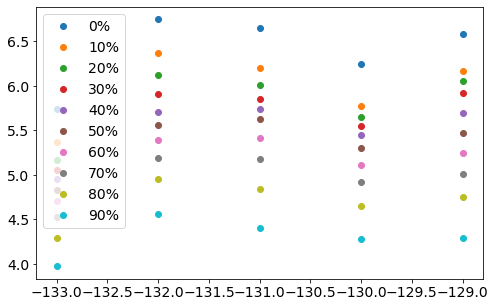

In [192]:
fig, ax = plt.subplots(figsize = (8,5))

for percentile in np.linspace(0,90,10):
    filtered_data = filter_data_percentile(scan_data, percentile)
    print(filtered_data[-130]['open'].shape[0])
    ratios = {}
    for key, d in filtered_data.items():
        trace_open = np.mean(d['open'], axis = 0)
        trace_open -= trace_open[100:250].mean()
        trace_closed = np.mean(d['closed'], axis = 0)
        trace_closed -= trace_closed[100:250].mean()
        ratios[key] = np.trapz(trace_open[200:])/np.trapz(trace_closed[200:])
    
    f,r = zip(*list(ratios.items()))
    
    ax.plot(f,r,'.', ms = 12, label = f'{percentile:.0f}%')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

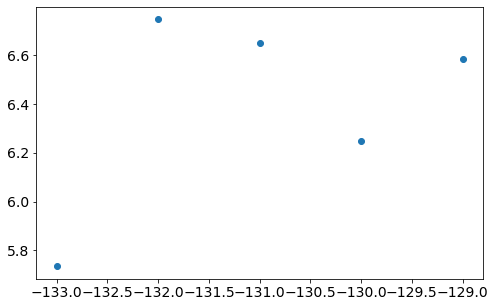

In [167]:
ratios = {}
for key, d in scan_data.items():
    trace_open = np.mean(d['open'], axis = 0)
    trace_open -= trace_open[100:250].mean()
    trace_closed = np.mean(d['closed'], axis = 0)
    trace_closed -= trace_closed[100:250].mean()
    ratios[key] = np.trapz(trace_open[200:])/np.trapz(trace_closed[200:])

f,r = zip(*list(ratios.items()))

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(f,r,'.', ms = 12)

set_fontsize(ax, 14)

-130.0
-129.0
-133.0
-132.0
-131.0


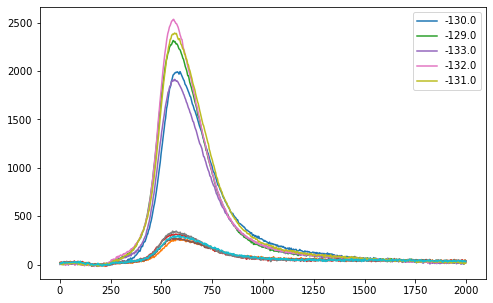

In [153]:
fig, ax = plt.subplots(figsize = (8,5))

for key, d in filtered_data.items():
    print(key)
    ax.plot(d['open'].mean(axis=0), label = key)
    ax.plot(d['closed'].mean(axis=0))
ax.legend()

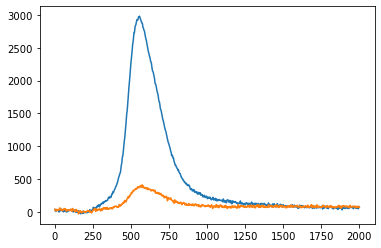

In [254]:
freq = -132
do = filtered_data[freq]['open']
dc = filtered_data[freq]['closed']
plt.plot(do.mean(axis = 0))
plt.plot(dc.mean(axis = 0))

In [171]:
np.trapz(do.mean(axis = 0)[200:])

901472.9904000002

In [255]:
np.trapz(dc.mean(axis = 0)[200:])

209904.5032000001

In [263]:
filtered_data[freq]['open'].shape

(100, 2000)

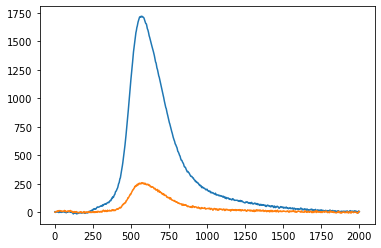

In [260]:
freq = -132
do = scan_data[freq]['open']
dc = scan_data[freq]['closed']
plt.plot(do.mean(axis = 0))
plt.plot(dc.mean(axis = 0))

(array([  6.,   6.,  16.,  30.,  70., 116., 167., 222., 191., 103.,  42.,
         15.,  10.,   3.,   3.]),
 array([-167235.2  , -132357.424,  -97479.648,  -62601.872,  -27724.096,
           7153.68 ,   42031.456,   76909.232,  111787.008,  146664.784,
         181542.56 ,  216420.336,  251298.112,  286175.888,  321053.664,
         355931.44 ]),
 <BarContainer object of 15 artists>)

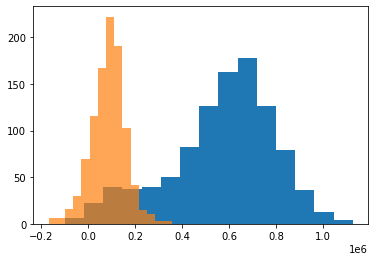

In [264]:
int_o = np.trapz(do[:,200:], axis = 1)
int_c = np.trapz(dc[:,200:], axis = 1)

plt.hist(int_o, bins = 15)
plt.hist(int_c, bins = 15, alpha = 0.7)

In [265]:
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

In [266]:
def gaussian(x, a, mu, sig):
    return a*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [295]:
int_of = int_o[int_o >= 0.4e6]
int_cf = int_c[int_c >= 0]

In [296]:
counts_o, bins_o = np.histogram(int_of, 15)
bins_o = bins_o[:-1]+np.diff(bins_o)[0]
counts_c, bins_c = np.histogram(int_cf, 15)
bins_c = bins_c[:-1]+np.diff(bins_c)[0]

In [297]:
popt_o, pcov_o = curve_fit(gaussian, bins_o, counts_o, p0 = (np.max(counts_o), np.mean(bins_o), np.std(bins_o)))

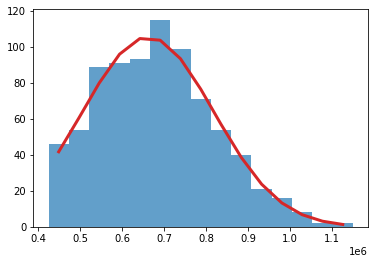

In [298]:
plt.bar(bins_o, counts_o, width = np.diff(bins_o)[0], alpha = 0.7)
plt.plot(bins_o, gaussian(bins_o, *popt_o), 'C3', lw = 3)

In [299]:
popt_c, pcov_c = curve_fit(gaussian, bins_c, counts_c, p0 = (np.max(counts_c), np.mean(bins_c), np.std(bins_c)))

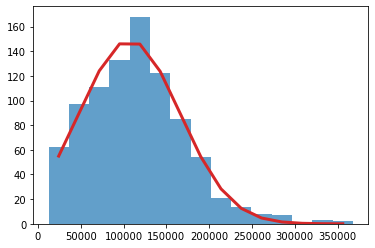

In [300]:
plt.bar(bins_c, counts_c, width = np.diff(bins_c)[0], alpha = 0.7)
plt.plot(bins_c, gaussian(bins_c, *popt_c), 'C3', lw = 3)

In [301]:
print(f'ratio = {popt_o[1]/popt_c[1]:.2f}')

ratio = 6.19
